In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
# Step 1: Load and preprocess the data safely
df = pd.read_csv('TSLA_stock_data.csv')

# Drop any unnamed or irrelevant columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Manually assign column names if needed
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Remove any header rows accidentally read as data
df = df[df['Date'].str.contains(r'\d{4}-\d{2}-\d{2}', na=False)]

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])  # Drop rows where Date couldn't be parsed

# Set date as index
df.set_index('Date', inplace=True)

# Convert all columns to float (just in case)
df = df.astype(float)

In [5]:
# Step 2: Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [7]:
# Step 3: Create sequences
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Predicting the 'Close' price

X, y = np.array(X), np.array(y)

In [9]:
# Step 4: Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [11]:
# Step 5: Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))  # One output: predicted close price

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


C:\Users\prasa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Step 6: Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 0.0260 - val_loss: 0.0026
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 8.4011e-04 - val_loss: 0.0023
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 7.4729e-04 - val_loss: 0.0020
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 6.4775e-04 - val_loss: 0.0019
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 7.6172e-04 - val_loss: 0.0015
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 6.2694e-04 - val_loss: 0.0025
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 7.1083e-04 - val_loss: 0.0013
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 4.6525e-04 - val_loss: 0.0013
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 4.6037e-04 - val_loss: 0.0011
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 4.1000e-04 - val_loss: 0.0011


In [15]:
# Step 7: Predict
predicted = model.predict(X_test)

# Inverse transform the scaled values (only for close price)
scaled_close = scaled_data[:, 0].reshape(-1, 1)
scaler_close = MinMaxScaler()
scaler_close.fit(scaled_close[:train_size])  # Use only train data for inverse
predicted_prices = scaler_close.inverse_transform(predicted)
actual_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f'MSE: {mse}, MAE: {mae}')

MSE: 0.0007790502138548124, MAE: 0.019869122931451915


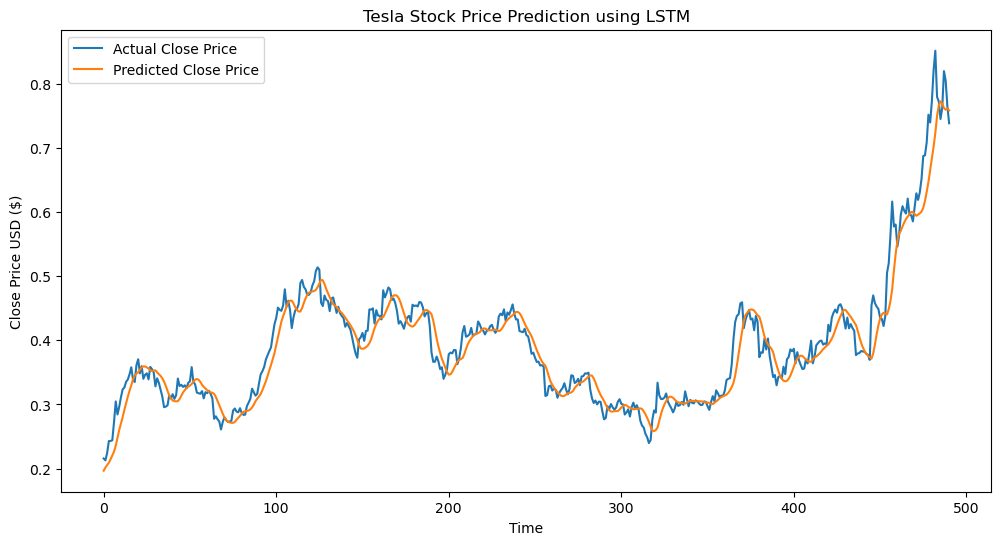

In [17]:
# Step 8: Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Tesla Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()